In [1]:
import math
import numpy as np
import librosa
%matplotlib widget
import matplotlib.pyplot as plt

In [4]:
librosa.__version__

'0.10.1'

## **Kapre**

In [7]:
def filterbank_mel(
    sample_rate, n_freq, n_mels=128, f_min=0.0, f_max=None, htk=False, norm='slaney'
):
    """A wrapper for librosa.filters.mel that additionally does transpose and tensor conversion

    Args:
        sample_rate (`int`): sample rate of the input audio
        n_freq (`int`): number of frequency bins in the input STFT magnitude.
        n_mels (`int`): the number of mel bands
        f_min (`float`): lowest frequency that is going to be included in the mel filterbank (Hertz)
        f_max (`float`): highest frequency that is going to be included in the mel filterbank (Hertz)
        htk (bool): whether to use `htk` formula or not
        norm: The default, 'slaney', would normalize the the mel weights by the width of the mel band.

    Returns:
        (`Tensor`): mel filterbanks. Shape=`(n_freq, n_mels)`
    """
    filterbank = librosa.filters.mel(
        sr=sample_rate,
        n_fft=(n_freq - 1) * 2,
        n_mels=n_mels,
        fmin=f_min,
        fmax=f_max,
        htk=htk,
        norm=norm)
    
    return filterbank

In [8]:
def filterbank_log(sample_rate, n_freq, n_bins=84, bins_per_octave=12, f_min=None, spread=0.125):
    """A function that returns a approximation of constant-Q filter banks for a fixed-window STFT.
    Each filter is a log-normal window centered at the corresponding frequency.

    Args:
        sample_rate (`int`): audio sampling rate
        n_freq (`int`): number of the input frequency bins. E.g., `n_fft / 2 + 1`
        n_bins (`int`): number of the resulting log-frequency bins.  Defaults to 84 (7 octaves).
        bins_per_octave (`int`): number of bins per octave. Defaults to 12 (semitones).
        f_min (`float`): lowest frequency that is going to be included in the log filterbank. Defaults to `C1 ~= 32.70`
        spread (`float`): spread of each filter, as a fraction of a bin.

    Returns:
        (`Tensor`): log-frequency filterbanks. Shape=`(n_freq, n_bins)`

    Note:
        The code is originally from `logfrequency` in librosa 0.4 (deprecated) and copy-and-pasted.
        `tuning` parameter was removed and we use `n_freq` instead of `n_fft`.
    """

    if f_min is None:
        f_min = 32.70319566

    f_max = f_min * 2 ** (n_bins / bins_per_octave)
    if f_max > sample_rate // 2:
        raise RuntimeError(
            'Maximum frequency of log filterbank should be lower or equal to the maximum'
            'frequency of the input (defined by its sample rate), '
            'but f_max=%f and maximum frequency is %f. \n'
            'Fix it by reducing n_bins, increasing bins_per_octave and/or reducing f_min.\n'
            'You can also do it by increasing sample_rate but it means you need to upsample'
            'the input audio data, too.' % (f_max, sample_rate)
        )

    # What's the shape parameter for our log-normal filters?
    sigma = float(spread) / bins_per_octave

    # Construct the output matrix
    basis = np.zeros((n_bins, n_freq))

    # Get log frequencies of bins
    log_freqs = np.log2(librosa.fft_frequencies(sr=sample_rate, n_fft=(n_freq - 1) * 2)[1:])

    for i in range(n_bins):
        # What's the center (median) frequency of this filter?
        c_freq = f_min * (2.0 ** (float(i) / bins_per_octave))

        # Place a log-normal window around c_freq
        basis[i, 1:] = np.exp(
            -0.5 * ((log_freqs - np.log2(c_freq)) / sigma) ** 2 - np.log2(sigma) - log_freqs
        )

    # Normalize the filters
    basis2 = librosa.util.normalize(basis, norm=1, axis=1)
    
    return basis, basis2

In [9]:
filter_log, filter_log_norm = filterbank_log(sample_rate=16000, n_freq=2048//2+1, n_bins=84, bins_per_octave=12, f_min=None, spread=0.125)
filter_mel = filterbank_mel(sample_rate=16000, n_freq=2048//2+1, n_mels=128, f_min=0.0, f_max=None, htk=False, norm='slaney')

### **log**

In [ ]:
plt.figure(figsize=(20, 15), dpi=300)
plt.plot(filter_log_norm.T)
plt.show()

### **mel**

In [ ]:
plt.figure(figsize=(20, 15), dpi=300)
plt.plot(filter_mel.T)
plt.show()

Triangular FilterBank

In [2]:
import tensorflow as tf
import numpy as np

def filterbank_triangular_log(sample_rate=8000, n_fft=2048):
        # Com o objetivo de ter 256 filtros e 8000 Hz na frequência de amostragem, teve-se de optar por Nfft de 2048, o que resulta em 54.4024 filtros por oitava, e numa frequência mínima de 151.3483 Hz.

        # Sendo assim, o Nfpo será 60, 5*12, e a frequência do último filtro, f256, será Si7 = 3951.066410048992 Hz. Resultando numa frequência máxima de 3996.975590329487 Hz.
        # Com isto, obtem-se pelo menos um bin em cada filtro, visto que f0*(2^(2/Nfpo)-1) = 4.7979 > 8000/2048 = 3.9062. Para uma Nfft de 1024, não era certo que obtivesse pelo menos um bin por filtro.
        #O primeiro filtro estava a zero.

        n_fft=2048
        sample_rate=8000
        Nfpo=60 #=5*12
        Nb =256

        #Cálculo da fmin e fmax
        f256 = 440*2.**(38/12) # Si7 = 3951.066410048992 Hz;
        f0=f256/2**(256/Nfpo) # fmin, 205.2672581380976 Hz
        fmax = f0*2**(257/Nfpo) # fmax, 3996.975590329487 Hz

        #Depois disto, dá bins em todos os fitros. Ver a linha 24 do getOctaveFilterBanck2.m

        i=np.arange(0,Nb+2, dtype=np.int32)
        k=np.arange(0, n_fft//2+1, dtype=int)
        f=k*sample_rate/n_fft

        fcf = f0 * 2.**(i/Nfpo) #3905.68454168

        #fi = np.concatenate(([f0], fcf, [fmax])) #fi =[f0, fcf, fmax] 
        #fcf está a incluir f0, fcf e fmax

        # Construct the output matrix
        H = np.zeros((Nb, n_fft // 2 + 1))

        #for i in range(n_filters), com isto são 256
        for j in range(Nb):
            fLow = fcf[j] 
            fmid = fcf[j+1] 
            fUpp = fcf[j+2]

            H[j, :] = ((f - fLow) / (fmid - fLow)) * ((f > fLow) & (f <= fmid)) + \
                            ((f - fUpp) / (fmid - fUpp)) * ((f > fmid) & (f <= fUpp))
            

        return tf.convert_to_tensor(H.T, dtype=tf.float32), fcf

2024-06-04 18:02:13.403653: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
H, fcf = filterbank_triangular_log()
print(H.shape)
print(fcf)

(1025, 256)
[ 205.26725814  207.65234879  210.06515286  212.50599236  214.97519306
  217.47308448  220.          222.55627687  225.14225624  227.75828325
  230.40470702  233.08188076  235.79016176  238.52991147  241.30149553
  244.10528385  246.94165063  249.8109744   252.7136381   255.65002913
  258.62053938  261.6255653   264.66550794  267.74077301  270.85177094
  273.99891692  277.18263098  280.40333801  283.66146786  286.95745535
  290.29174037  293.66476792  297.07698816  300.52885649  304.02083359
  307.55338552  311.12698372  314.74210514  318.39923224  322.09885311
  325.8414615   329.62755691  333.45764463  337.33223583  341.2518476
  345.21700307  349.22823143  353.28606802  357.3910544   361.54373842
  365.7446743   369.99442271  374.29355082  378.64263239  383.04224785
  387.49298438  391.99543598  396.55020355  401.15789497  405.81912518
  410.53451628  415.30469758  420.13030572  425.01198473  429.95038611
  434.94616896  440.          445.11255373  450.28451248  455.5165

In [ ]:
plt.figure(figsize=(20, 15), dpi=300)
plt.plot(H)
plt.show()

In [ ]:
plt.figure()
#plt.plot(librosa.util.normalize(H, norm=1, axis=1).T)
plt.plot(H)
plt.show()

## Meu filterbank

In [ ]:
def getOctaveFilterBank(fs=16000, Nfft=4096, Nfpo=12, fmin_user=None, fmax_user=None, edges=''):
    if fmin_user is None:
        fmin_user = 440 * 2 ** (((1 + 1) * 12 + 0 - 69) / 12)
    if fmax_user is None:
        fmax_user = 440 * 2 ** (((8 + 1) * 12 + 9 - 69) / 12)
    if edges == '':
        edges_flag = False
    else:
        edges_flag = True

    if fmax_user > fs / 2:
        fmax_user = fs / 2

    i0 = np.ceil(Nfpo * np.log2(fmin_user / 440))
    fmin = 440 * 2 ** (i0 / Nfpo)

    i = np.floor(-i0 + Nfpo * (np.log2(fmax_user / 440)))
    Nb = int(i - 1)
    fmax = 440 * 2 ** ((i + i0) / Nfpo)

    i = np.arange(Nb + 2)
    fi = fmin * 2 ** (i / Nfpo)

    H = np.zeros((Nb, Nfft // 2 + 1))
    fcf = np.zeros(Nb)

    k = np.arange(Nfft // 2 + 1)
    f = k * fs / Nfft

    for j in range(Nb):
        fLow = fi[j]
        fcf[j] = fi[j + 1]
        fUpp = fi[j + 2]

        H[j, :] = ((f - fLow) / (fcf[j] - fLow)) * ((f > fLow) & (f <= fcf[j])) + \
                  ((f - fUpp) / (fcf[j] - fUpp)) * ((f > fcf[j]) & (f <= fUpp))

    if edges_flag:
        fcf = np.concatenate(([fmin], fcf, [fmax]))

    return H, fcf

In [11]:
H, fcf = getOctaveFilterBank()
print(H.shape)
print(fcf)

NameError: name 'getOctaveFilterBank' is not defined

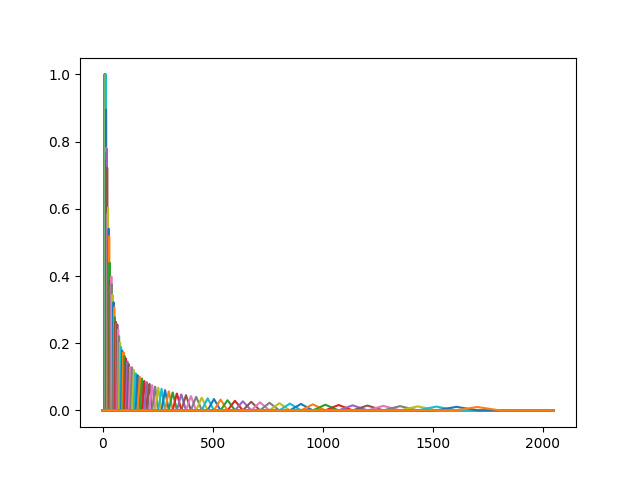

In [ ]:
plt.figure()
plt.plot(librosa.util.normalize(H, norm=1, axis=1).T)
plt.show()